In [1]:
import os
import math
import glob
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from scipy import stats
import copy
import datetime

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import concatenate, Permute, Dense, Dropout, LSTM
from keras.constraints import maxnorm, nonneg
from tensorflow.keras.constraints import MinMaxNorm, Constraint, UnitNorm
from keras import backend

from attention import Attention

/Users/Zach/miniforge3/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
def window_mean(arr, num_steps, axis=1):
    assert num_steps < arr.shape[axis], f'num_steps ({num_steps}) must be a smaller than the length of the specified axis ({arr.shape[axis]})'
    assert arr.shape[axis] % num_steps == 0, f'num_steps must be a factor of the length of the specified axis ({arr.shape[axis]})'
    assert isinstance(num_steps, int), 'num_steps must be an integer'
    return np.array(np.split(arr, num_steps, axis=axis)).mean(axis=0).astype(np.float32)

def pull_apart(arr, lengths, axis=1):
    """Split array using the desired lengths. Lengths should add to the length of the array."""
    return np.split(arr, np.cumsum(lengths)[:-1], axis=axis)

daily_data = np.load('../data/dailyt30_features.npy', allow_pickle=True)
monthly_data = np.load('../data/monthly_features.npy', allow_pickle=True)
daily_target = np.load('../data/dailyt30_target.npy', allow_pickle=True)
monthly_target = np.load('../data/monthly_target.npy', allow_pickle=True)
month_range = pd.date_range(datetime.datetime(1979, 1, 1), datetime.datetime(2019, 1, 1), freq='M')

# Note that these must be factors of 30...
data = [
    daily_data,  # 1day
    window_mean(daily_data, 3),  # 3day
    window_mean(daily_data, 10),  # 10day
    window_mean(daily_data, 15),  # 15day
    monthly_data,  # 1mo (30day)
]

#Concatenate datasets and save lengths to pull them apart later
scales = [d.shape[1] for d in data]
data = np.concatenate(data, axis=1)

#Adding a lag to monthly targets
lag = 1
data = data[:-lag,:,:]
monthly_target = monthly_target[lag:]
month_range = month_range[lag:]

In [3]:
test_years = 7  # Num years to use in testing

LEN_DATA = len(data)
NUM_TRAIN = LEN_DATA - (12*test_years)
NUM_TEST = LEN_DATA - NUM_TRAIN

print(f'{LEN_DATA=}', f'i.e. {LEN_DATA / 12:.1f} years')
print(f'{NUM_TRAIN=}', f'i.e. {NUM_TRAIN / 12:.1f} years')
print(f'{NUM_TEST=}', f'i.e. {NUM_TEST / 12:.1f} years')

x_train = data[:NUM_TRAIN]
x_test = data[NUM_TRAIN:]
y_train = monthly_target[:NUM_TRAIN]
y_test = monthly_target[NUM_TRAIN:]
month_range_train = month_range[:NUM_TRAIN]
month_range_test = month_range[NUM_TRAIN:]

LEN_DATA=479 i.e. 39.9 years
NUM_TRAIN=395 i.e. 32.9 years
NUM_TEST=84 i.e. 7.0 years


In [4]:
# Remove seasonality and downward trend
deseason = False

def deseasonalize(y_train, y_test, y_train_dates, y_test_dates):
    y_train = xr.DataArray(y_train, coords={'time': y_train_dates})
    y_test = xr.DataArray(y_test, coords={'time': y_test_dates})

    climatologies = y_train.groupby('time.month').mean()
    y_train = (y_train.groupby('time.month') - climatologies).values
    y_test = (y_test.groupby('time.month') - climatologies).values
    return y_train, y_test

def detrend(y_train, y_test, y_train_dates, y_test_dates):
    slope, intercept, r, p, se = stats.linregress(month_range_train.astype(int), list(y_train))
    y_train = np.array(y_train - (intercept + slope * month_range_train.astype(int)))
    y_test = np.array(y_test - (intercept + slope * month_range_test.astype(int)))
    return y_train, y_test

if deseason:
    y_train, y_test = deseasonalize(y_train, y_test, month_range_train, month_range_test)
    y_train, y_test = detrend(y_train, y_test, month_range_train, month_range_test)

In [5]:
def reshape_features(dataset, timesteps=1):
    X = dataset.reshape((int(dataset.shape[0]/timesteps)), timesteps, dataset.shape[1])
    print(f'Converted from shape {dataset.shape} to shape {X.shape}')
    return X

timesteps = x_train.shape[1]

# Normalize the features, requires reshaping to 2D (?)
scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,x_train.shape[2]))
x_test = scaler_f.transform(x_test.reshape(-1,x_test.shape[2]))

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,1))
y_test = scaler_l.transform(y_test.reshape(-1,1))

# Revert it back to 3D
x_train = reshape_features(x_train, timesteps)
x_test = reshape_features(x_test, timesteps)

print(f'{x_train.shape=}')
print(f'{y_train.shape=}')
print(f'{x_test.shape=}')
print(f'{y_test.shape=}')

Converted from shape (18170, 11) to shape (395, 46, 11)
Converted from shape (3864, 11) to shape (84, 46, 11)
x_train.shape=(395, 46, 11)
y_train.shape=(395, 1)
x_test.shape=(84, 46, 11)
y_test.shape=(84, 1)


In [6]:
# Build ensemble model
num_features = 11

# Loop over each time scale (e.g. 1, 3, 10, 15, 30)
models = []
models_inputs = []
for num_days in scales:
    model_input = Input(shape=(num_days, num_features))
    
    model = Permute((2,1), input_shape=(num_days, num_features))(model_input)
    model = LSTM(64, return_sequences=True)(model)
    model = Dropout(0.2)(model)
    model = LSTM(32, return_sequences=True)(model)
    model = Attention()(model)
    model = Dense(1)(model)
    
    model = Model(inputs=model_input, outputs=model, name=f'EALSTM-{num_days}')
    model.compile(loss='mean_squared_error', optimizer='adam')
    models.append(model)

2022-03-08 21:30:11.630520: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-08 21:30:12.435643: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-03-08 21:30:12.960747: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM N

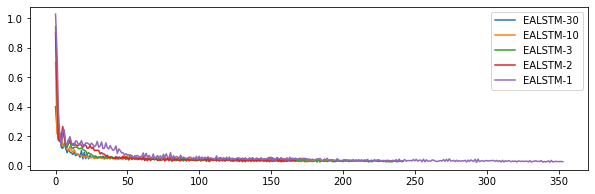

In [7]:
# Model x input is a list of arrays corresponding to each timeframe, so split the concatenated dataset into its parts
x_train_sets = pull_apart(x_train, scales, axis=1)
x_train_sets = [d.astype('float32') for d in x_train_sets]

x_test_sets = pull_apart(x_test, scales, axis=1)
x_test_sets = [d.astype('float32') for d in x_test_sets]

checkpoint_path='./testmodel.h5'
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=60, mode='min', min_delta=0.001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

plt.figure(figsize=(10, 3))
for model, x_train_model in zip(models, x_train_sets):
    history = model.fit(
        x_train_model,
        y_train,
        epochs=500,
        batch_size=64,
        verbose=0,
        validation_split=0.3,
        shuffle=True,
        callbacks=keras_callbacks)

    plt.plot(history.history['val_loss'], label=f'{model.name}')

plt.legend()
plt.show()

In [8]:
# Predict
results = {}
for model, x_train_model, x_test_model in zip(models, x_train_sets, x_test_sets):
    pred_train = model.predict(x_train_model)
    pred_test = model.predict(x_test_model)

    # Inverse the transforms
    pred_train_inv = scaler_l.inverse_transform(pred_train)
    pred_test_inv = scaler_l.inverse_transform(pred_test)
    y_test_inv = scaler_l.inverse_transform(y_test)
    y_train_inv = scaler_l.inverse_transform(y_train)

    results[model.name] = (pred_train, pred_test, pred_train_inv, pred_test_inv, y_test_inv, y_train_inv)

2022-03-08 21:31:08.545292: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-03-08 21:31:08.836929: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memo

EALSTM-30 -----------
Test RMSE: 844,072.6
Test NRMSE: 0.0784
Test R_Square: 0.937


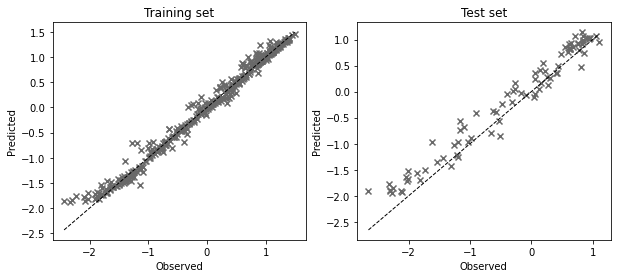

EALSTM-10 -----------
Test RMSE: 776,133.5
Test NRMSE: 0.0721
Test R_Square: 0.947


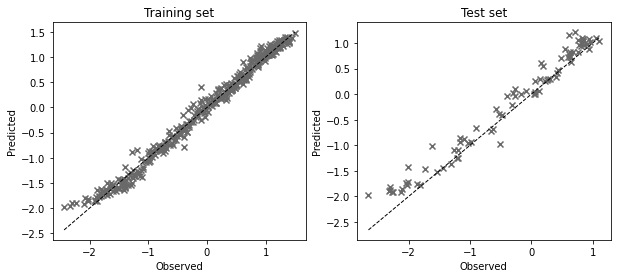

EALSTM-3 -----------
Test RMSE: 776,813.9
Test NRMSE: 0.0721
Test R_Square: 0.947


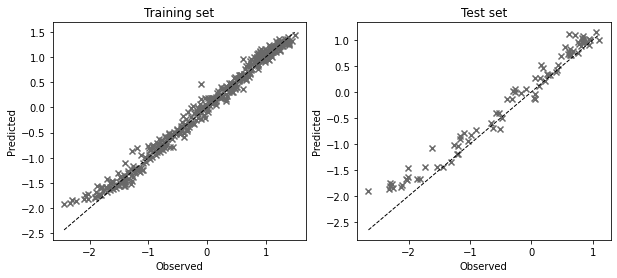

EALSTM-2 -----------
Test RMSE: 737,245.7
Test NRMSE: 0.0685
Test R_Square: 0.952


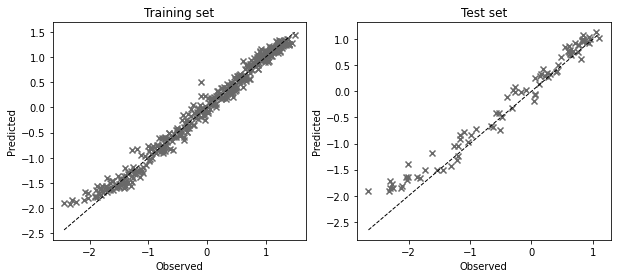

EALSTM-1 -----------
Test RMSE: 704,475.8
Test NRMSE: 0.0654
Test R_Square: 0.956


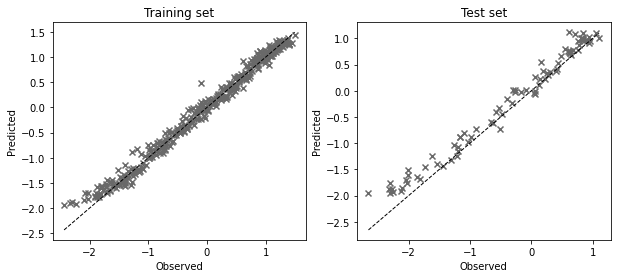

In [9]:
# RMSE
for model, result in results.items():
    pred_train, pred_test, pred_train_inv, pred_test_inv, y_test_inv, y_train_inv = result
    print(model, '-----------')
    
    rmse = math.sqrt(mean_squared_error(y_test_inv, pred_test_inv))

    # NRMSE
    y_max = y_test_inv.max()
    y_min = y_test_inv.min()
    nrmse = rmse /(y_test_inv.mean()) 

    # R2
    r_sq = r2_score(y_test, pred_test)

    print(f'Test RMSE: {rmse:,.1f}')
    print(f'Test NRMSE: {nrmse:.4f}')
    print(f'Test R_Square: {r_sq:.3f}')

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].scatter(y_train, pred_train, c='dimgrey', marker='x')
    axs[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
    axs[0].set_xlabel('Observed')
    axs[0].set_ylabel('Predicted')
    axs[0].set_title('Training set')

    axs[1].scatter(y_test, pred_test, c='dimgrey', marker='x')
    axs[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
    axs[1].set_xlabel('Observed')
    axs[1].set_ylabel('Predicted')
    axs[1].set_title('Test set')

    plt.show()

In [10]:
results_train_df = pd.DataFrame({model: (result[0].flatten()) for model, result in results.items()})
results_test_df = pd.DataFrame({model: (result[1].flatten()) for model, result in results.items()})
linreg = LinearRegression(positive=True)
linreg.fit(results_train_df, y_train)
linreg.score(results_test_df, y_test)

0.9582279128548123

In [11]:
for model_name, coef in zip(results_test_df.columns, linreg.coef_[0]):
    print(model_name, ':', coef.__round__(2))

EALSTM-30 : 0.41
EALSTM-10 : 0.25
EALSTM-3 : 0.0
EALSTM-2 : 0.0
EALSTM-1 : 0.34


Note that running this notebook multiple times gives very different results for the weights of the different model. Meaning that it's not the 

I am not necessarily convinced that this weighted approach is better than connecting the models by a dense layer. A more complex connection between them might be better if e.g. the 1-day model is best at predicting SIE at low SIE, and the 10-day is better at higher SIE values. 